<a href="https://colab.research.google.com/github/Savana-Alshubayli/facial-emotion-recognition/blob/main/Facial_Emotion_Recognition_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1.import dataset, preprossing and augmentation

Found 695 images belonging to 7 classes.
Found 285 images belonging to 7 classes.
Found 297 images belonging to 7 classes.
Train samples: 695
Validation samples: 285
Test samples: 297


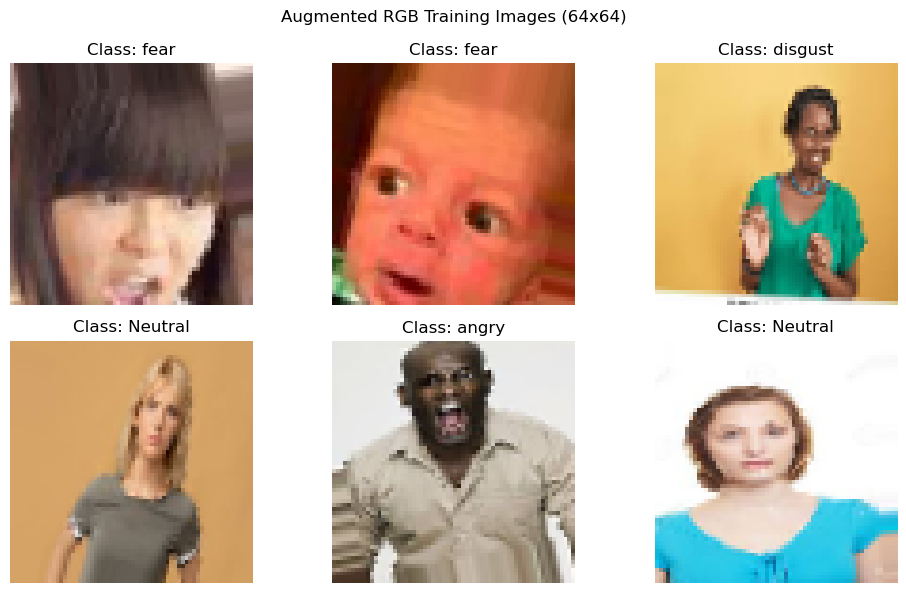

In [ ]:
import os
import shutil
import random
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Dataset Splitting
source_dir = '/Users/ebtehal/Desktop/expressions3'
base_dir = 'split_dataset'

# Create base split folders
for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(base_dir, split), exist_ok=True)

# Split each class folder
for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)
    random.shuffle(images)

    train_imgs, temp_imgs = train_test_split(images, test_size=0.2, random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

    for split_name, split_imgs in zip(['train', 'val', 'test'], [train_imgs, val_imgs, test_imgs]):
        split_class_dir = os.path.join(base_dir, split_name, class_name)
        os.makedirs(split_class_dir, exist_ok=True)
        for img in split_imgs:
            src = os.path.join(class_path, img)
            dst = os.path.join(split_class_dir, img)
            shutil.copy2(src, dst)

# Images Preprocessing
img_height, img_width = 64, 64
batch_size = 32

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')

val_generator = val_test_datagen.flow_from_directory(
    val_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')

test_generator = val_test_datagen.flow_from_directory(
    test_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical', shuffle=False)

print("Train samples:", train_generator.samples)
print("Validation samples:", val_generator.samples)
print("Test samples:", test_generator.samples)

class_names = list(train_generator.class_indices.keys())
images, labels = next(train_generator)

plt.figure(figsize=(10, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(images[i])
    class_index = np.argmax(labels[i])
    plt.title(f"Class: {class_names[class_index]}")
    plt.axis('off')

plt.suptitle("Augmented RGB Training Images (64x64)")
plt.tight_layout()
plt.show()


2.CNN model with optimal hyperparameters

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

input_shape = (64, 64, 3)
num_classes = train_generator.num_classes

model = models.Sequential([
    # Conv Layer 1
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),

    # Conv Layer 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Conv Layer 3
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),  # Fully Connected Layer
    layers.Dense(7, activation='softmax')  # Output Layer
])

# Compile
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_66 (Conv2D)              │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_66 (MaxPooling2D) │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_67 (Conv2D)              │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_67 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_68 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_68 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_18 (Flatten)            │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 684,103 (2.61 MB)

 Trainable params: 684,103 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

3.Train the basic CNN model

In [ ]:
epochs = 150

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator
)

Epoch 1/150


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.1658 - loss: 1.9420 - val_accuracy: 0.2105 - val_loss: 1.9160
Epoch 2/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.2135 - loss: 1.9096 - val_accuracy: 0.2386 - val_loss: 1.8956
Epoch 3/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.2398 - loss: 1.8894 - val_accuracy: 0.2596 - val_loss: 1.8562
Epoch 4/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.2665 - loss: 1.8600 - val_accuracy: 0.2737 - val_loss: 1.8158
Epoch 5/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.3000 - loss: 1.8058 - val_accuracy: 0.3333 - val_loss: 1.7513
Epoch 6/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.3501 - loss: 1.7666 - val_accuracy: 0.3333 - val_loss: 1.6955
Epoch 7/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.3585 - loss: 1.7104 - val_accuracy: 0.3123 - val_loss: 1.6951
Epoch 8/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.3530 - loss: 1.6815 - val_accuracy: 0.3368 - val_l

4.Accuracy graph

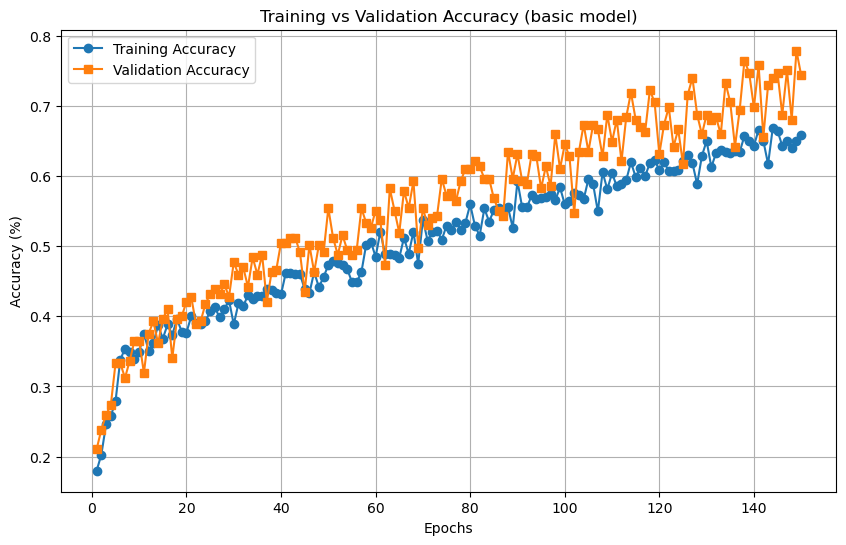

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs_range, acc, 'o-', label='Training Accuracy')
plt.plot(epochs_range, val_acc, 's-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy (basic model)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()



5.Evaluate model (classification_report, confusion_matrix)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
              precision    recall  f1-score   support

     Neutral       0.61      0.74      0.67        42
       angry       0.83      0.78      0.80        45
     disgust       0.66      0.71      0.68        41
        fear       0.67      0.73      0.70        41
       happy       0.74      0.72      0.73        40
         sad       0.62      0.49      0.55        41
    surprise       0.91      0.85      0.88        47

    accuracy                           0.72       297
   macro avg       0.72      0.72      0.72       297
weighted avg       0.73      0.72      0.72       297

Final Training Accuracy: 65.90%
Final Validation Accuracy: 74.39%


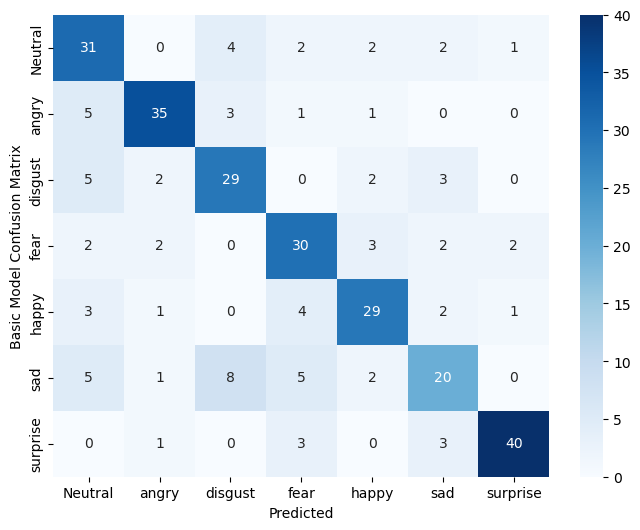

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix , accuracy_score
import seaborn as sns


Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

true_labels = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Classification report
print(classification_report(true_labels, y_pred, target_names=class_names))

# Training and Validation Accuracy
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]

print(f"Final Training Accuracy: {train_acc * 100:.2f}%")
print(f"Final Validation Accuracy: {val_acc * 100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(true_labels, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Basic Model Confusion Matrix')
plt.show()


6.balance learning to avoid bias

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

y_train = train_generator.classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

print("Class Weights:", class_weights_dict)


Class Weights: {0: 1.0342261904761905, 1: 0.9193121693121693, 2: 0.9108781127129751, 3: 0.9928571428571429, 4: 0.9928571428571429, 5: 1.1962134251290877, 6: 1.002886002886003}


7.Enhancment model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(64, 64, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))  # Reguralization

model.add(Dense(7, activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_69 (Conv2D)              │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_69 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_70 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_70 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_71 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_71 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_19 (Flatten)            │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,143,751 (4.36 MB)

 Trainable params: 1,143,303 (4.36 MB)

 Non-trainable params: 448 (1.75 KB)

8.Train enhancment model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=150,
    callbacks=[early_stop],
    class_weight=class_weights_dict
)

Epoch 1/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.2006 - loss: 2.7381 - val_accuracy: 0.1719 - val_loss: 1.9411
Epoch 2/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.2822 - loss: 1.9369 - val_accuracy: 0.1754 - val_loss: 2.0791
Epoch 3/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.3273 - loss: 1.6962 - val_accuracy: 0.2070 - val_loss: 2.2961
Epoch 4/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.3337 - loss: 1.6781 - val_accuracy: 0.1368 - val_loss: 2.4802
Epoch 5/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.3762 - loss: 1.5614 - val_accuracy: 0.1474 - val_loss: 2.7199
Epoch 6/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.3741 - loss: 1.5989 - val_accuracy: 0.1825 - val_loss: 2.8893
Epoch 7/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.3759 - loss: 1.5815 - val_accuracy: 0.2035 - val_loss: 2.9347
Epoch 8/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.3776 - loss: 1.5710 - val_accuracy: 0.

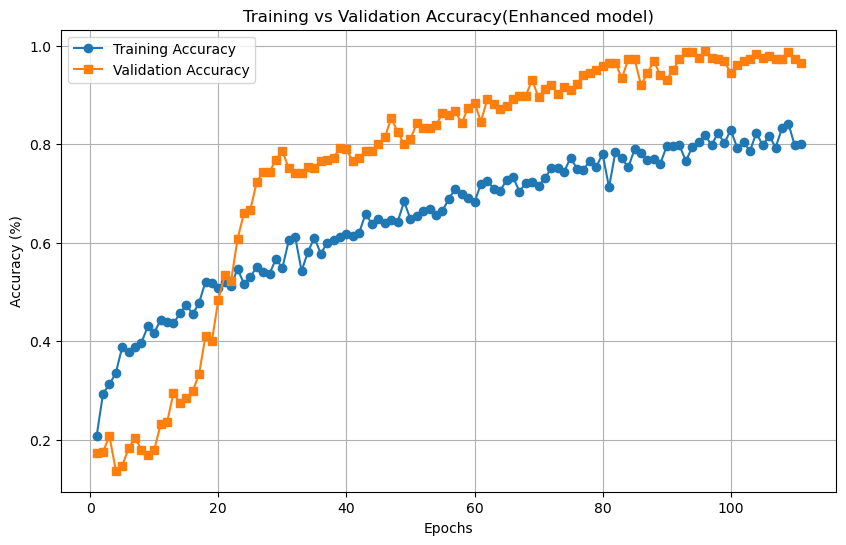

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs_range, acc, 'o-', label='Training Accuracy')
plt.plot(epochs_range, val_acc, 's-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy(Enhanced model)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()


9.Evaluate model (classification_report, confusion_matrix)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
              precision    recall  f1-score   support

     Neutral       0.93      0.93      0.93        42
       angry       0.96      0.98      0.97        45
     disgust       1.00      0.88      0.94        41
        fear       0.95      1.00      0.98        41
       happy       1.00      0.95      0.97        40
         sad       0.91      0.98      0.94        41
    surprise       0.96      0.98      0.97        47

    accuracy                           0.96       297
   macro avg       0.96      0.96      0.96       297
weighted avg       0.96      0.96      0.96       297

Final Training Accuracy: 80.00%
Final Validation Accuracy: 96.49%


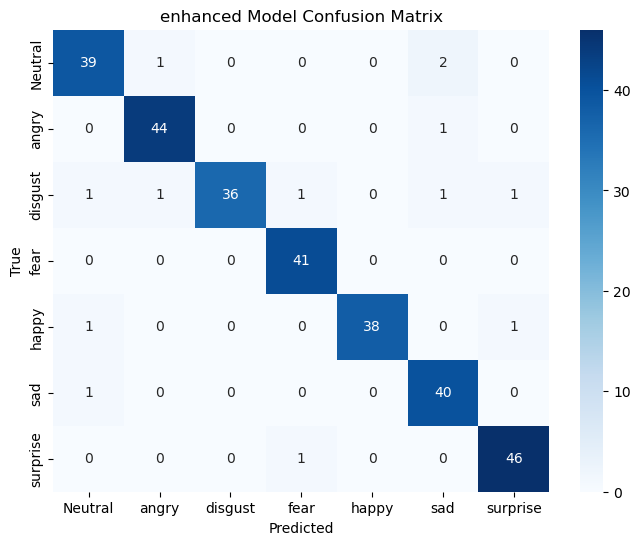

In [ ]:
from sklearn.metrics import  accuracy_score

Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

true_labels = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Classification report
print(classification_report(true_labels, y_pred, target_names=class_names))

# Training and Validation Accuracy
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]

print(f"Final Training Accuracy: {train_acc * 100:.2f}%")
print(f"Final Validation Accuracy: {val_acc * 100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(true_labels, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('enhanced Model Confusion Matrix')
plt.show()


#baseline model

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

baseline_model = models.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(7, activation='softmax')
])

baseline_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

baseline_model.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_72 (Conv2D)              │ (None, 62, 62, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_72 (MaxPooling2D) │ (None, 31, 31, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_73 (Conv2D)              │ (None, 29, 29, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_73 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_20 (Flatten)            │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 64)             │       401,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 407,015 (1.55 MB)

 Trainable params: 407,015 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
baseline_history = baseline_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30

)

Epoch 1/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.1907 - loss: 2.0065 - val_accuracy: 0.3018 - val_loss: 1.8452
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.2833 - loss: 1.8369 - val_accuracy: 0.3333 - val_loss: 1.7722
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.3377 - loss: 1.7562 - val_accuracy: 0.3404 - val_loss: 1.6713
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.3046 - loss: 1.6850 - val_accuracy: 0.3333 - val_loss: 1.6321
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.3255 - loss: 1.6568 - val_accuracy: 0.3579 - val_loss: 1.6573
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.3137 - loss: 1.6918 - val_accuracy: 0.3719 - val_loss: 1.6075
Epoch 7/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.3526 - loss: 1.6418 - val_accuracy: 0.3684 - val_loss: 1.5846
Epoch 8/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.3507 - loss: 1.6189 - val_accuracy: 0.4140 - v

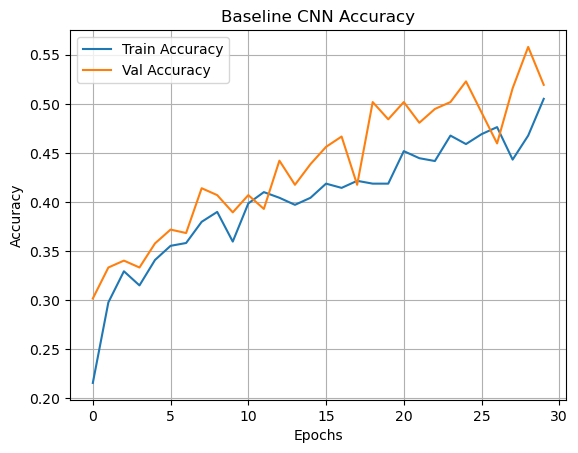

In [ ]:
plt.plot(baseline_history.history['accuracy'], label='Train Accuracy')
plt.plot(baseline_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Baseline CNN Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
              precision    recall  f1-score   support

     Neutral       0.61      0.26      0.37        42
       angry       0.62      0.67      0.65        45
     disgust       0.42      0.54      0.47        41
        fear       0.48      0.37      0.42        41
       happy       0.48      0.65      0.55        40
         sad       0.55      0.39      0.46        41
    surprise       0.68      0.94      0.79        47

    accuracy                           0.55       297
   macro avg       0.55      0.54      0.53       297
weighted avg       0.55      0.55      0.53       297

Final Training Accuracy: 50.50%
Final Validation Accuracy: 51.93%


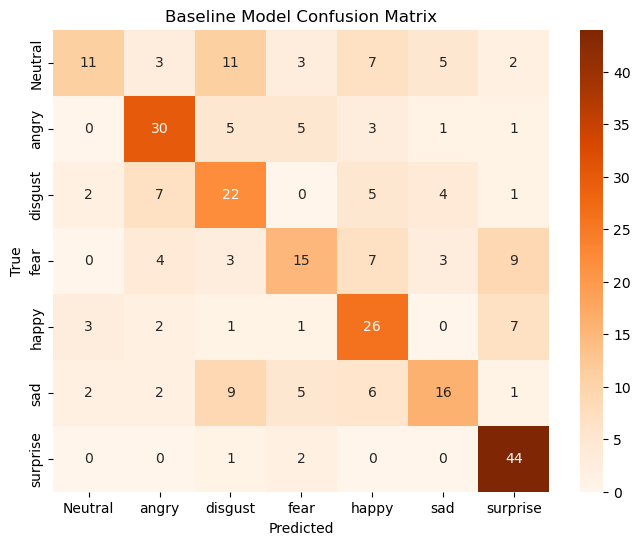

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


baseline_pred = baseline_model.predict(test_generator)
baseline_y_pred = np.argmax(baseline_pred, axis=1)
baseline_true_labels = test_generator.classes

print(classification_report(baseline_true_labels, baseline_y_pred, target_names=class_names))

train_acc = baseline_history.history['accuracy'][-1]
val_acc = baseline_history.history['val_accuracy'][-1]

print(f"Final Training Accuracy: {train_acc * 100:.2f}%")
print(f"Final Validation Accuracy: {val_acc * 100:.2f}%")

cm = confusion_matrix(baseline_true_labels, baseline_y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Oranges")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Baseline Model Confusion Matrix')
plt.show()